# Image pre-processing for digit classification

In this notbook we use some functionality of the python image processing libraries `PIL` (https://pillow.readthedocs.io/en/4.2.x/index.html) and `scipy.ndimage` (https://docs.scipy.org/doc/scipy/reference/index.html).

### Install an import required packages

In [1]:
# for handling base64 encoded images (needed to transmit a JPG efficiently in a JSON payload)
import base64
from io import BytesIO

# modules needed from PIL
from PIL import Image, ImageEnhance, ImageOps

# the Multi-dimensional image processing from scipy
from scipy import ndimage

# out good old friends
from matplotlib import pylab as plt
import numpy as np

# may be needed to display images
from IPython.display import display

### Some generic helpers

In [2]:
class LocationOrder:
    """
    This comparison class can be used to orders locations (bounding boxes)
    found by ndimage.find_objects from top-left to bottom-right.
    """
    def __init__(self, loc, *args):
        self.y, self.x = loc
    def __eq__(self, other):
        return self.y == other.y and self.x == other.x
    def __lt__(self, other):
        above = self.y.stop < other.y.start
        if above:
            return True
        below = self.y.start > other.y.stop
        if below:
            return False
        return self.x.stop < other.x.start
    def __gt__(self, other):
        return not self < other and not self == other
    def __le__(self, other):
        return self < other or self == other
    def __ge__(self, other):
        return self > other or self == other
    def __ne__(self, other):
        return self != other
    
def area(loc):
    """
    Comput the area (==number of pixels) of a location found by ndimage.find_objects
    """
    y, x = loc
    dx = x.stop - x.start
    dy = y.stop - y.start
    return dx * dy

### Project acces in the IBM cloud

In [3]:
# The code was removed by Watson Studio for sharing.

## Reading/loading an image

##### Generate a PIL image from a base64 encoded string

In [4]:
base64string = "iVBORw0KGgoAAAANSUhEUgAAAIAAAACACAYAAADDPmHLAAAgAElEQVR4nOzdd3QU9f7/8c+9Xu+9XumQAqH3LghiRVAURRRFjQ3hBkI2BEGkCIS6QEjfhNB77z303nvvvZPee7LZ8vz9MTPZ2c1uskG/9ffNOY/jOZjsJp/X+1PmM7MzQvz3/vqLjb8KIf7q6Sle8vQUL3UW4m+dhfibRiNe9vQUf/f0FH/v1lD8w6uz+KdXZ/FPT0/xikYj/qXRiH+N6CpeHegpyilG9hDlFep/H9FVvDqiq3hVoxH/8vQUr3h6ileU1+vWUPzD01P8XaMRL2s04mXl/T09xUvK72bnd/6/rzJ+OQy9s03g3RqKfyiBD/UUryjhKQEP7iYqBGtERe1XolKQn6is9RRVFP49RVWF+t+D/ETlID9RWfuVqBSsERUHdxMVlCJRCmOoXBRKQXh6ir93/r9i+MNfdoPvbCd0JXClZ9sNWiOqxa5o3yN2WfsvszZ2DM3a0DEse2PH+fotnU4q8jd3OpW/qdNJRe6Gjruz1r0blrHu3bCklR0GP1vc5ssr0xu2LSoSm6JQF4R6dOhcvBhs/7b/KwbhIHCh6u0ajXh5sE3gAz1FOW03UUH7laik9RRV/PuIqnu0Lg0TV3Xok7OxY6g++oOTxm1dnpl3fox5x8eYdnyMacdHku0q+zwxHfgZ04GfMe76EmP0hxi3SgxbPsSw5QPJZknu+vdOZq99Z03Kyg5j78xr8kGgp3BRRoxgjaioFIQyOgyWC6Lz/40MDr9KHOKV4G1D9+8jqgZ6CpdnK9p9lbvlg3mF2z68bt75MUV2d8d8qDfmS0Mw3x6L+bkOc4IO8lZLClYDNsyrwbgKclZB9irMaXMxPQ7D9GAqxvPDMBz+N4U7v6ZwU2cKN3amcGMnCtZ1zMxa8+6upCXtBl+IrPO6fx9RNchPVNZ2ExUGeopyysgw2GZkKKEQ/r/4cji3K0O8OvSRPUT5ID9R2b+PqKrtLVzjV73hlbel0zrjjo8yiwLf1xPzhSHwQAvpc6FwFVBG5pUS00owrgTjCswGmX4FZv1yScZyTI9CMJ7/jcJ9fdBv6IR+/fvo179P7pp3rycvaTf+WlSDdlqNqKaMDMraQSkGJwrhf20xWIVfUvDBGlExyE9U1mpEtUsz6rfP2vReeNGwvvNjzEd+xnxrDKTOgcIVYFoB5hVSiDiyEdhin1lm2iwxrsJsWC7RL7MoWIY5fxnmvKWY8pZiSl+K8e4kCg/3Q7+xCwVrO1KwtiNZK97a/Wx+Ky9lmlCmCI1G/EuZHkophP91X3Z7vRL8UE/xijLMB/mJyoGewuX5std75m15f61VT785GnPyLMyFyzAbloFxGRiXg0lmXgtEA3uBY8BJ4IoTLoPZhukymM6C4TgY9mEujMZcsAFT/hJMebLcxZhyJMb0RRhuT6TwQF8K1rxHwZr3yF35zrPERe3Gbx9XoZF/H1FVvVYooRD+1xWB3eF+cEPxDyX4YI2oqAzzT5a2/SZ/a+fTyiLOfMoX09MQTPlLMOuXYNYvxVy4FLNhKRhXg2kbmA6C+SxwSQrTHvMlC+NFa4aLYLL5N9MliVH6frNBRX8Uc8FOTHnrMOUswpS9CGP2IoxZCyXxsyk8N4yCjZ+Sv+pdcla8nZm8sJ1up3/5xsr0oO0mKiiF4GCN8D++EIqGfHvD/Yiu4tWRPUR5raeoEugpXG7NbfZx/tbOp4tW7Gc1mBKmY8pfJClYjFm/GLN+JWbDdjCdkEIz21CCNFyAwgugP19cgQP5dsj/z6w/j7nwAmbDBem/hecl+jOY8/diylmPMWsBxswFGDPnY8yYjzF5PoVXRlKw8RPyV75L9vK3MhMXttVpvYS7fx9RVfuVqDTQU5RTLxY7/y8pgmJzvXqeVwe/XVu1ad7mTuuLDs/O+GBKnIYpd4Ekf6E07Oo3g+EYGM+D6TyYLsj/PQ+G81B4DvQlKFA7W1z+WchzINdGnvT95oJzmPXnMOvPYi44i7ngFKbc3RizlmPMmIcxfa4kZS6Fl34nf0NX8la8Q/bSDs+fzGzez1EhyB3Fdm3wP+arWPh2h3sv4Z688s3fDNEfZpq2f4Tp8E+YYiIx5czDlDMfU+58THlLMRfsxGw4hdlwFrPhHBjPgeEcFJ610Jeg4Iwk74BF7i7I2SrbIsk9ADkHIGc/5B6DvDOSXBs5itMWuacx553BXHAGc74s9wCmrPUY0+ZIUmdjTJiN/tSv5K3qRN7yt0lb1G7PqQD3DtrewjXIT1RWFor/U9cGdof8wQ3FP0Z0Fa9qu4kKWk9RRdtbuF6YVvfNvE2dThu3dcG0uwemOxMwZs3FlC3LXYK5YBfmwjMSg/RfFHoHCo5B/l7I2wI5qyF7CWTNhkw7MmZDxixJuixNJXUmpM2B9GWQsR4yt0L2QTn0UxbZKlnSv5nzTmHOOy3JPYIpYy2GlFmS5FkYnkaSv/tncpe9TdaSDpnPZrYapvUS7lqNqKYeDf4nTQnFtm/Vc72618cua9uvcOuHmcboLhjPDMCYHIUxczbGzDmYshdhztuJWX9aUnga9HYUKI5D3g7IWQvZC6Wws2ZZZDqQMQvSZ1pLU0mdCakzJCkzIHm6RdJ0SFkCaRsgcz9kn5RknYSsExbZJzDnnMScdxJz7klMOYcxpq/GkDwTQ9IMDEkz0F8ZR96aLuQufYu0Be32bB5Zrlmgp3DRfiUqjewhyjuYEv7bFYHd+V495Ad6ChdtP1Eja/27C43RH2Lc/inGe5Mwps/CmDELY+ZcTDmbMOcfxVxwEnPBSXAk/zDkboXsxaqwZ1pkqmTMhIwZxaXbSJsOqSopKslRFklRkKiSMA0SZ0DyCkjfBlnHILM4c/ZxTDknMOUcx5S5G2PKYgyJURgSojA8CSd/54/kLHmTjIVvPL8SVK+rtrdw1XqKKrZTwn/HIrAKXxnyNRrxL2XIn/qjcNs2vkqL/I3v3zRu/RDjge8xxkVgTJuBMX0GpswlmPMOYs4/jjn/BBQ4kLcNspdC1gzILIW90DOmS9JV0qbbhB8FKSrJ0yRJskRFJCSoxEdCXCTEz4LklZC+HzKPQoZK5lHM2ccwyYzpGzEkzsAQH0lhXCQFp34lZ1lHchZ34FlUi2FTNaK6snegHC7arAv+y4ugxPCVIf/GjKaf6Dd3yjRs+RDD2YEYkqMwpEZhSJuFMWsjpryjmPOPQf4xaQ4vOK5yGHLXy0P39BJEQYYD6TbSFNMkqSopsuRIiyRZokpChCReFqfQQawOYnQQPw9St0PGEUhXyTiCKfMopqwjmDL2YUxaQGFcBIWxEehvTCB3zSdkL+pA6rx266dqRHWtRlQL1oiKtotD8V88EhRb7CmHeNpuooJWI6oF9BEed+e0+EG/8f1MQ3RXDFeGY0iJxJAyDUPaPEw5+zDlHsGcdwTyjkK+St5+yF4hBetIRhRkTLNItyfSIs1GqixFpSj4CElSBCRGQKJOkqASL4sLl8SqxIRDTBg8D4OY6ZC0AdIPSdIk5oxDmDIlhpR1FMbqKIwJR/8giJwNn5O9sANJs1pv2DyyXDNtb+Gq/UpUUm8cdS6+OPzPDV/Iiz0lfGWxp9WIatp+okbs4nYjDJs/wLC1K4Z7WgxJERiSIzCmr8CUcwhT7iHMeYch74jKAcheAxmRpUt3JMJamizVRkoEpOgskmVJ4RaJKgnhEK8SFw5xYZJYWYzseajFs1B4FgIxMyB5K6QdhNSDkHoA0g5gSj+IMeMgxtTtFMZGUfg8FP3TUHKjPcle8AZpc9ve3Dq8XPNAT+Hy32E6sApfvdLXfiUqBXoKl4A+wuP5oja/F27qTGH0xxjuTsSQGI4hKRJjxgZM2Qcx5RyEvEPWstfJw3TEC9BBmgOpOkgNt5YiS1ZJCrOWGAYJKvGhFnGhEBcCsSoxsueyZ7KnwRZPguH5LEjeCan7i5jS9mNM348xbQ+FcbPRPwtB/ySE3G1SEaTOaXNr46hyLZQjhIGeotx/xUhQbM5X93wl/NjFbUYUbuxM4Y4vMTwYhyEhDENiBKaMbZiy92POOQC5ByFPlrNDOixLC/9zpYZZpNhItpEUKklUhECCSrwsThEMsSoxwfBcEQTPZE8DJU9kj1Vil0LK3iLmlL0Y0/ZhTNtLYdx89E+D0T8JInfHN2TNb0/q7Da31IeJDqaD/9CRoKgA1As+ZdgP6CM8Yhe2GVG4sROFWz/CcH8shrgQDInTMWXswJS5D3P2Psjdb5G5AtLC/jwOQw+VJMuS1EKkwNWKgg+2iFMEQWwQxKg8D4LngZJngZbgi8KfCo9lj6bCowB4GACPIyBhMyTvgaQ9mJP3YErdgzFtD4b45eifBKJ/FEju9m/ImteetNltbgb0ER6OpgPxH7gwtFr0qcNXev7FafU/z1/7Xmbhpo8ovDsGQ2wwhoQojBk7MWXuwZy9F3L2SbKj5cOv0D9BiEWKSrIDSSGQFGyRKEtQiQ+G+CCLuCCIDbSIUXkeCM+nwjPZ06nwNACeyB6rPJoCD1UeyJ4vhKRdRUwpuzCm7MIQvwL9owD0DwPI2fw1WXPbET+91YaAvqKWvengP2qfoNi8r17ta/uJGieCa7yXv+bdTP3GLhTeHENhzFQK4yMxpm3HmLELc/ZuyN4jyVgt98pgSeofkGIj2QGrwIOsJQRBQqBFvCxOJXaqJEYRAM9VngVIoT8NgKdT4InsseyRYjI8nAwPJsODSXBf5ZEOEqIhcQck7sCUtAND8g4K45ZT8HAyBfcmk72xJ5lz2hEf1XKRMhJovxKVlAtNVJtFf1oBWM37yg6fcjZP20/U2Dzq1ddyVr9zS7/+fQovDaHweQCFcTqMadEY03dgztoF2bslaQsgORCSgyxS/gD16yQHSpIcSLSREAgJUyHeRpxMCT02QAq8yBR4PgWeqRSFPlnyWDEJHk2ChyoPJsF9rcU92V0t3A+E2HWQsB3it2FK3I4haTuFsUspuD+JgtvjyFr6AZlzXueBrtGIkF6ipra3cFWmAwc7hn+8AJShX1n0BfmJylN/FG5BXqJu+vI3NunXvY/+WF8Kn06hMCYEY+pWjGnbMWfuhKydkLVd2llLmmotWS2wDFQ/Z/uaaokqCbYCIF4Wp5giiVWJmWIJ/flkybPJ8HQyPJ0keaLyWPZIa/FQK12zqLg/Ee4pJsBd2Z0JcHcSPFsG8dEQF40pMRpDYjSFz+ZScG8i+dfGkjn/TdJmtsm8MMmje0Af4eHfR1TVdhMVlHMHnf+kRaHjob+3cA3oK2rFLWwTULC2I/rd36B/PInCZwEYk9ZgTI3GnLEdMndAZrR0mJU4BRIDrCX9CWxfM3GKtQQ74mVK4HGTJbGyGBvPJ8OzSRZPJ8FTreSJ7LHKo4nwUOXBBLivck8xHu6Ohzvj4c44yW3Zk4UQtwXitmBM2IIhYQv6x9MouDuBvNO/kTG7LSkzWsesHfbqa1ov4a71FFWUs4h/xnkDuyd3lHk/pJeoeTGs3hd5q97JKtjUFf29ceifaDEkrMCYsgVzejRkbIP0ddKGitLwtuH8RygW9uTiigKfZC3GxvNJ8FwLz1SeauHpRHii8niiFPqjCZKHsgcq98dL7snujpPYBn97LNySPV4AsZshZjPG+M0Y4jejvx9IwZ1x5Oz8mYxZbYmLaLE5yEvUnaoR1YP8ROWBnqLcnzEVWB3vK/O+fx9RVdtP1AjyFg2zVr51u2DNe+gv/or+0QQKY+dhSN6MKW0LZGyFtDXyEDvJIuE/SbwDcZMgTguxWgxPJpBxbRTEaiFG5bliouTZRCnwpxPh6QTJkwnwWOXRBHg0Hh6qPBgnuS+7J7s7Du6OhTsqt8fALRs3/eGGP9wLh5iN8HwDhriNGGLXUnBnPPk3xpC1ogsZM9twK6jOwABvUUe9ZWwzFZSpCIpdzaPs9E39UbgFeIs68Qvbzshf/R4FB3ujfzCOwqdhGJI2YkrZBOlbIG2j3MsmWsTb0kLCnyBeW/y14xyInUj+gzHc2eXHsXk/c2zez5xd4YXh8Th4PkHyTDFe8lT2ROXxeHg8Dh6pPBxnCf3BWLivcm8M3FW5I7vtL7kluzna4obs+mh4MBOercf8fD2FcespfL6U/Jv+5J3/jYzZb5AS1Spr7W8vvx7QR3hoNaKash54kVGg2Lw/1FO8UrTZ01fUOjzFvXP+qnfJ3/ARBffGUvBwEoaENRiTNkDaJkhdLx1GxY6H2AkWcTbi1ewVSGlUP2/72ur3jR1fJPvWKE4u6s3Rub2sxBz7VRX4OGtPxsGTsfBY5ZHsocoDxRi4L7s3Bu75w13ZHdltf7g9Gm6p3BwFN2TXVa6Ngmsj4cEseLoW0/O1FMasRf9gGvk3RpG96wfSZ7QhVtdsS1hvUU/rJdzVU0FZRoFih3xencU/B3qKcuqhP2Nph3P5q96l4NwvFNzzpzB2IYaEtZhTNkDqOukQKmZccaogiB0PcX8i29e28/7Zt0ZyYlEvjsz9sZgr6/vBs7Hw1MaTMZLHKo/8JQ9VHsju+8P90ZJ7o+HuaLg7SnJnFNxWuSW7KbsxUnJ9JFz/Ha6pXP0drvwO92fC09UYn62m8PlqCm5PJv/a72Qu+ZD06a9xaZJHb/VUoJxC7uzkLqFV71eG/mCNqKgM/XenNx2Uv/JdCnZ+Q8HdUegfh2OIX40paS2krJfOkD0fA8/HQkwpYsf9eUp5r+ybIzix8CeOzPnBrivrvODpGEvgT8bAE394LHvkD49GWzwcDQ9U7o+G+6PgnsrdkZI7KrdHwq2RcOt3yc3f4cbvcGMEXJddk10dAVeHS64oRsLDBfBkJYXPVlL4ZDH510aRe9yX9OmvkRTR4naol2ikTAXKZWXO7hI6XPiF9BI1g7xFw+ylb8XmrX6f/CtDKLjrjyF2GcaEVZCyFuKnwTN/i+eKMfbFOCHWye+LcfAez/0xPBrF6SW9ODz7e4cur/23HPhoa0WBj7L2QHZ/FNwfKbk30hL63d/hjuy2yq3f4eYIixsj4MZwuC67Jrs6HK4Ogysql4fCpaFwZRQ8Worp8QoKny6n4G4oeVeGkbm6G2lRrbkdWG9MkJeoq/US7rYLwpIKoFjvH+gpygX5icrynFL/4czm/nkr3iF/3w/k3x6B/kkUhbErMCethoT58GQ0PFV55ohtgTgQY6O07y8qPuv3u77Ji8OzPEt0eU1veDxK8khtJDyUPVApCv13i7uyOyMsbo+AWyo3h0tuDIcbw+C67NowKXDFlaGSy0Ph8m+SS7KLQ+DqOHi4DMPjZeifLCXv6khyzw4mbUY7knQtYgN9ROOAvqKWsiCU75LicG/A7navcqInpJeoGdJPNMle8mZM3sr3yb86hIK7EyiMWYYpfgUkLpd6z5ORFk9HWXv2Ap6rvMjPPx1F8tlBHJr5Take7+0vhf1oJDz83doD2f0R1u6NgLtqw+HOcLitGAa3ZDdVbgyD60Ml1xS/wdXf4IrK5d/g0hCLi0Pg4q9wQXYjEPODJegfL6bg/gzyLg0ha+OXpE2TRwE/Ud/egrDEAlCf4y9a+PmJ+g9mNBubt/xt8vd+R/7Noegfz6Dw+RJIWC7thT/+3doTG09Hls0zO8r4GoYHwzk291sOzfi6VMmnBsLDEZIHNu6PgPvD4Z6Nu8Mkd1Ruy24Ntbg5FG78JrmuooR+dYjkyhC4PAQu/yq5JLsouzDY4vxgODcI7szE+HAR+kcLyb86htzTA0mb/jpJ4c1jQ/qLZgF9RS3lXIH6cwa2RVCs9yvbvcEaUTukn2iStfiN2NwVHcm7PIiC22MpfLYIU9xSeK6DR8NtjIDHKk8csVMoRQVjR0nfb+f1H+3tx8HpXznFcGcoPBhucV8xTHJPdncY3B0quSO7rXLrN8lN2Y3f4MYQyfUhcG0IXPtVclV2RXb5V7g8GC4NhouD4eIgyYVBcN7GuV8kF0bAvQUUPpxPwZ1Ics//QubabqRGtuLW1Dpjg/xE/akaUV3rKaqorx2wWwCd5ZM9Az1FOa2nqBLQR3gEeYuGtyMbDc5d+ha52z8n79qv6B9Ow/BsAcQtlHvNsOIeKYbD4zJ6UgInXyP/5q8cjPrSKWeXeMKDoZL7sns27g6Fu7/BHRu3h8AtGzeHqEL/1eLar3BtMFxVuTJYCv3yYLg0SFIU/C8W5wfCOdlZlTN+cHUSpnvzKHgwj7xLI8k56k1qRCviQpueD9eIpkWHhfJawM4RgWXlr5zsCfQULgHeok64RjRNmf/6wdylb5F3xpf8G6PQP5mHKWahtP+tNJythyqP1IaV7nEpSn2Nodzc3IsDUT2c8mx/Xzn43+Cejbu/wd0hcEd220ZR6L9a3PgVbgyG64OlwIsMgquD4IrK5UFw+Re49AtcVAyECwOl0BVFwftJzvjBmQFwWnYrCv292eTfCiP3rB8Zyz4iNaIlx8a6fhOqEQ3kqdzRWkDq/Z6e4u/qlX+oRjTYN65K15wlb5K7rit5V36h4H44+sdz4fk0uD/EvgdD4MFvFg/L6FEJnPh5w51fOTKzBwciP3dK/tWBcG+I5O4QVeC/Wrv9K9weDLdUbspuDLaEfn2Q5Jrs6i8WV36BKwPhsuySTAn9gp/kvOzcAMlZWVHovpJTvnBKA+eGYbwzi4K7M8k7/xtZu34kVdeS58GNt4b0E02CNaK2gy3ivwj1BZ7qs33hGtH0yfQWoTlL3iR3//fkXfkV/cNZGJ/OkQ+BBst+tXZf5UEZPXRCKa/xdN+/2R/R3Sk3N/wg/Q13ZXdUbg+ydkt2U+0XuCG7/gtcUxsIVwdKgV8ZCFf84LLskuziAMkF2Xk58HO+krOyMxrJadkpDZzUwEkfyQkfuBpMwe0Z5F+dTM4pDWkz2pMU2iwrzFu0VB8RjOgqXrWaBtTDf9Fxv5eoG6wRrdIXtIvNWfwmued8yL+lRf9gBubHQXBnENx14N4gS3HcL6MHTijlNY7P+YL9um5OSTvlLf3OdxS/wG3ZLcVAyU3ZDdl1G9f8JFdVrvhZgr80wOLiALjoCxdUzmvgnOys7IwGzvjAadkpHzjVH07KTsiO94eTfhhuRZF/O4qc075krPyYlPAWXJ5Uc0igj2isXDgysoco79VZ/LNoGlBv/Pj3EVUD+giPUC/R6ERAje9zFncgd3M3ci9oKLgXieHRDGmIvD0Q7ih+sXZX5V4Z3C8DB6+RdcGHfeGfOOX8kq8sf8NtlaLA/azdUAyA67JrKldlVwbAFV+4LInd1YvT876Q3nPhlxjO9oeLPnDBB87Lzqmc9ZFCP+MDp/tbnOoPJ70lJ2TH+8ExC/PFCeTfiiT3/HCy9/5ASngLngY2ig72ES2UxaBySFg0DVgN/72Fq7L4exTVNCxnUQdy931D3uVhFNyLxHhvMtzys3Zb5Y6Nu4qBpbtXBg5e487m79gb3tUpaSe8iv8tt/zg5gCLG2q+cF12TXZVY+2KBi5LDOf6c35hj2Lv+2CjJ5zvb3HOG87Kzqic9oZT/SxO9oUTsuMqx/rCUS844gXHNBTc0JF3NYCc431JjXqdpJCmWbp+4jXlkLDYNFB0qddXopL8DfXDvEXL1Hlt72Yv7EDuqb7kX59Awd0IeQ70tXZL5fYAa3ecYVssTigqMuvXOjWvO3vDPirV5eVfSr+v7d+iuOGrClwD12xc9ZFckV32gcv9ixjO9ePUnM/svvf5BZ9LoZ/rJzkrO9MXTquckp3sCye8LI57wbF/S47KjsgO98FwYTz518LIOeFD+rIPSQlrwYUxbv0DfUTjkF6iplYjqlkdDXRTLvjwFFVCeomagT6i8Zqh/+yYvfANsld/QO6ZfhTcCqbw9mS4oSnupsZBMZTRnTJw8Bp7Q7uU6mDkx+Rd6Cf93vb+nhsaKfTrPnBNdlWtv+SKTAn+ksRwri+n5nRz/P4RH8PZvpIzKkXBe8FJlRP/lhyXQz/WR3K0DxxROdwbDvXGdHwAeVeDyTnzG5lbepAS2pyHU+qvCu8rmgd5ibpTfxRu2m6iQtGmkFdn8c+RPUT5omP/vqL5tbD6w7IXvEHO1u7knh9Iwa0QjNeHwPX+UsMobti46SMXhAZuOesFiuW2UmiW10k58iPbJr7O1nGt2fh7PTb+Xo9Vv1QustznnyzxEtyc5wEnX7M4oXL8NTjeGk69Jzn5HpzpCme7wdnP4cJ3cPFHOXhvySXZxX5wsR/XV/RgT8iHDh3QfaQK3wtOq5z6N5yUnfg3nOgjOa4KXXGkt+Rwbzj0s8XBn8m/OIHc8/5kH+xNcmhzYgOb3A3rL1qr9wSUrWGhbP1O/VG4BfmJ+sEa0er59Barsxe8Qc4+T/IuDif/+mTMV/rBNW+V/nJByG7YuNlfLggn3Cqj673gSk+4+Amc7whn2hG/qSFLvESJdvuXcxz68dZwTHZU5UgryWHZoVZwqCUc7QDHOsLJT+Dst3C+N082f8Oe4A9KdHbup3Dm33BaVhR6H4sTfeB4b8kx2dGfJUd+hsM/w+FekkOyg73gQC848BMFxweSd3kq2Yd6kTrrTZJDmrNi8N86KtOAfx9RdURX8Wq3huIfQj3/h3qJRqE+ok3SrNYXs+a3J+d4H/KujCX/8nC40k9yVeWaynVvazfK4GYprn4Plz6Dcx3hdBuLUxaXZ7iXGP4qzUvoD7VUhf6adejOBn+oJRyUHWgJB1rA/hZkb2nM2l9eZe0Qdzb7N2XH5DfZHdSpmIsLusHpPnC6N5zqDSdlJ36G4zaOKaH3sjj8k+TQT3DwJzj4o+TAj7BfUnjgJ3IvTiH7qDdpS94nOaQZp8e49Q/pL5oFeIs6gZ7CRflImVD2/pXNnyg/0S5rXnuylr1HzvFe5F+bgv68N1z2klzpa3FV5VoprtvqZ3HDxvV/w+Uv4VxnON3OKugiJ9tYDeX3l9QqMfzU6MbOh+5U8C1hvxQ++1qwe9Srxd53hW851g31YJv2dXYFvZfb+U0AACAASURBVM+uoPe5v/oLOPUznFT0ghO94Ljs2E9wVOWI7PBPcOhHi4M/wsEf4MAPsF/xPez7HtO+78k5PZycE4PIWN+N5OBm3J1UZ76yKaSsA4Z6ilfEyB6ivH9PUTVYI2qH9xXNj2rdfsqa147sNV3IOeVN/uVxFJ7tBZf+LbmsckXlqi0va9eKM1/pg/Hc93DdC671hks94Gwn6zm6JKqhPH5DA8fhb23kOPQ/GDz7WvB0ce1Sp5/lPv9k3VAPkqO7WUI/8RMcVzn2IxyVHfkRDv9gcUimhH7ge8l+2b7vYO93sOc72ONJzhFvck6PIGPrFyQHN+PplIZHdf3Ea0HeoqHWS7grt50Rg+WTP8ru39XAOiOy5rYje9PH5Jz2I/fsIIznesHF3nBJ5bJaH2tXbFy1z3j2OzLWtSR9qStZy8tZz83OOG5tw6C/WzV69LBXSN3SyPnQyxg8+1rA3uZs+OXlUgtgiZdglc9LsL0p7GwL+7vAse+k0I/9AEdVjtgG/z0clB34TrL/Oyn0fZ6SvZ6wxxP2fAu7vyV3ryc5Z/3J3PstScHNiAloeE/nLdqG9BNNlIXgiK7iVaFc7x+qEQ1CfUSbRxFNFmbObUf2zh7knhlEzrFemM/3ggu94KLiZ7hUgssKuUCu2HG+O/rdTUmdI4oULcaKvGbn32yoenbqlkYcnFCB3aPLcX9RLceBOxO6veDV4e+Vwr8/p4ZT4S/xEhyfWBG2NYFoRXPY9TYc7glHvpcc/k5ySHbwOzjoCQdk+2X7PGHft7D3Wyn0Pd/Abtmub8jf3ZPsE0PI3OtJcmRbkoKaEuIr2hddKCLfhk4E+YnKRQtAjXg9ZlrznZlz2pG983Nyz/5KzuFv4PxPkgv2qAtDdsnGZZVz3eF4ew5OqMA6X8GBEYJ7wYLU2X/BdKCp9VBdGtte7WzgRaG3chx6KcGzR+Js71/iJXg610MKfqtsS2PJ5saw4y04+CUc+lZyUHZAtv9b2P8N7PsG9qrs+Qb2fA27v4ZdX8POr2FnTwp2fkXWQS+y9v1EyozXSQpsyvJBf/sw2Ee0UM4Ojuwhygutp6ii/UHUCPQRjcN9xBsJM1pezpzzOtkHviH3lB95R76Gcz/IfrQ4r3JB5eKPcPEna5d+gjPd4Fi7okB2j7Ysmo6OFqTN+SuGXQ1KDtWZoB0FXlJPtwreTuh2gmd3c+KX1XE6/A0DXy4e/mbZpsawqRFsbATb3oT9X8CBryX7v4Z9Knu/hr09YU9P2K34CnZ9BTtlO77EuONLsvZ8S9b+3qQufI+kwKacGF1tQLBGtAryEnWVu4wI/57SZd/hGtE0wlt0SIhqeTlz9utkHehJzrF/k3u4J5z5Hs6qnPteVRQ/wHmVCzbOfgFH2lkHceQ1qwLY/utfSJvzEvkb3R0HWpag7fVyZ0O3M8fbBi9pxnFtRacL4KbOVQ7eTvgb5fA3yNY3hOi3YF8P2NcT9n4l2aOyW7brS9j5Jez4Enb0kGzvgXH7F2Tu6E7WAS9SF71DUmATjo+uOlDXT7wW1lvUUz48Ivw9hUtAX1ErvK9orusv3sqY3ZbMue3IOvAt2Ye+o+DIV3DaE86onFU59519Z7+Fo29bGr9IKzjSnqcrm7HbX2rAzQP/Qvqcv5GzskrJgZYYcqvi7+Uw8NJCLzl4djVDv7Wx0+Gv8vkr+g0NrYd8da+3DX+dojHs+AD2fgl7voTdPSS7esDOHrDzC8kO2fYvYJvEHP05mdu6kbn7O1IXv0fi1CZcH+cxTect2ipHAkF+orLwl4aC2sE+okWYr3g7Y1ZbMhe/RfbB78jc210qgFPfwmmVM57FqYvieBc4+JrU0LYhHGwJR9rD8fe4HGU5fEqf8zKZi161UzBOsPcexQK3mdOdCd1O8OxqBjubcX+W84u/y8FVHQ/5G1XBq8Nf2wDWyDa0hl2fwe4vYNcX1sFv/wK2fy7Z9jls6w7R3WFrdzKiPyVz59ekrf6AxKlNuDW+1qIoP9Eu1Es0Ui4WFcop4DBv0TLSW7yrFEDW3h5k7vmMgsM94OQ3cMrGaXt6wuG3rBv5QIviQRxuD8c68nRl86JGuh/6Mhnz/oFpb1PHgTobtL0e7jD0UoLfZR08O5vBDueH/w0DX0a/vmHpQ74S/lqb8Fc3gFX1YXUj2NoJdn4OO7pLtsu2fQbRsq2yLZ+RsbUrGdHdSVvVmcSAJtwcX2tJuI94I6SfaBLQR3j49xRVhfK5v2CNaBWuEe9lzGxD5qI3ydr1GZm7PqXg4OdwoqfFSZVTiq/h+Kewr5V1A+9zEMKBVnC4A/HrXitqqIvav5Ex75/oN9VyEGgZg7YN215Pd6a32wTPjqawoykbBjq3+n86u4bzQ746/NWq8FfVh5X1YUV9WNcGtn8mhb6tmyRatvVT2CLb/CkZmz8iY/PHpK3sRGJAY26O91gSphFvhmtEU+XUsFDu9aMugIyFHciIfp/MnV0pONAdjn9pceIri5Oyw52lBlQ37F4HASgOtIGjnYoaas+wl8ic9wq5K6s5DrQsQTsTuDOh2wTP9qboNzs3/+8e/i/ner0S/ho74a9Uhb+iHiyvByubwdYuEP2pFPrWT2HLJ7BZZVNX0jd1IW3tW6St6EhiQGNujfNYqusv3grvK5o7LID0GW3IWNCBjM3vkLnjYwr2d4NjPSyOq5zoAQfesjSibePutVMURYXRGo52ZsMg6TTtyv5/IXPev8ha8CqmXU1KDtVh0C2Kv6fDwMsWepFtTYlfVPrW7yqfv5K9op7jXl/SkL+6vk34cvDL68GyerCsLiyrD5s6wdausKUrbJZt6gobP4aNH5O+8QPS1rxJ2vL3SJzSmBvjPJaF+Yq3lb0Af0/hIqb+KNym9Bb1wvqL1hH9Rcf06a+RvuAN0te3JWNbFwr2fQJHu8PRzyXHZEc/g72vWzfgbpsGtm1828I40pnjAZazeHeC/0HWgnLoN9ZSBeog2NKCthu4zZxuG/pOVeg7rEOXSDt48Yscn3gqGvpn1XCu15c05NsLf2ldyZK6sLQ+rH0TNn0k2fgRbOwi2dCF9A2dSFvdgZSFbUmQC0DnI95RXyNovwDmtyd9XRsyoj+gYE9XONwdjqgc/hR2v2bdcLYNu6uZ1MNsA1AXxqGO3F/YrKjRDo38G1nzy5GzpLLjQJ0N2l4PL0vodoJXNnLiF5ZcADfDXF6g19uZ70sKf3FdWFwHFtWBNW/Axg9hg2y9JG3d+6SubE/KgjYkTG7EjTEeyyK9xbth3qKl4wKIeo30uW1JW92cjK2dKNj9ERzqpvIJ7Gxt3Wg77DSqo6JQF8aBt8ne8U5Rw63s/xey55cne2EFDFvqOwi1DEHbC9t2eHcmdPUO3tYmpC51vAN4fHwF53v9Gke9XhX+slLCXyhb1R7WfyBZ1xnWdiJt7XukrmhHytzmJExuxPWxHstLLYC0qNakTW9F2oqGZGx+n7ytneHAJ7KPYUdrqYG223CmIGyLYm87ONyF6GHlixrwxtRXyF5YkfwVro5DLUvYpQXuZOhFO3jy8fwqn78W7/mhLmUL3pkhf5kq+CVy8Fbh14YFtWF+bVjRDtZ2grWdMK1+n7Q175C6vC1J4bWdL4CE8OYP0qJak7q8ARmb3iMnuhPs7yrZ3srSONuaqBqutIKQi8K2MHa1hMMfcXNWk6JG3PLLS+QsqEjOwkoYtzRwHKrDoJsVf2+HgdsJvVjwja138ORVffz8mkVFcHBUOVIX1S4h+DL2entD/hJVr7cX/vzaMK+WVARrOmJY/R5pq94mdVkbksJqkzCpEYdHVhlutwDURwExYU2vpk1rTcoiD9I3vEPWxndh30ew43XrhrFttNIKwlFhHPyA7G0drXrS4/By5C6sTMEKd8eh2uPoPW0DL6mnOwrd3rG8vaH+T+n1JQz5SvgL7IQ/txbMqwMrOqBf+Q5pK98kZWETEkNqkzCpIYdGVBpmdxGoLoDHwY32pk1rTeq8OqSvf5vMdW/D9vbWjWLbYLbFYK8gHBXG3rfhUFcOjnctKoAdQ/5G7sLK5C6qgnFDXcfBlhh0CT28zKH/RwXvzJBfSvjzVOHPrQVzasGc2uiXdyBt+RukzG9EwtR6xGsbsuG3f/ZSDgMD+opaRYeB6gK4E1hveVpkK1Ln1CVtdVvSV7XGtLaBdaOoG2uLncZ0VBRFhaEqjh2t4OAnxK/uYDUKPNFVIG9RVfKXuGCOdlBMtr3aUdh2A/8Dob9o8CWt8B0N+baLPUfhz5HNrgmza5Izuzapy9qTPKcOCVOkAoj0Ex8V2wiyPRdwRus+ITWiFamzGpC6vAUpC2tiXClvaCgNs7lxCQVhZ4QorSj2fwQHP2XDoFes1gJ5i6qSt7ga+pUejn+2tKDt9XDbwEsK3VHw65wIvqy9vqQh3958bxW+FDyzJBkz3EieW5/kmR7EaxvydEKdhzpf0aXYVrD6bKDOR7yzz7+yb2pEK1KnNyFlfnVSFtSgYGkd6wZRF4MzBVHSSLG1CezsAAe6cX9+a6tR4MrkV8lf5EL+YldMG+o7/vmSenapgZchdGcWd2UKvpReX9p87yB880wPUqe7kRTlQmKEO/HahtwfV/uUTiM+CPcRbwT6iMbaH0QN/56iarHrAcJ9xcepupakTmtK8rzqpMyvTu6CmtYNUqwYSimIEgujMWxtCvs/gQOfET20gtW+QMqsKuQvdqVgqTvmjQ0cv0ZJYdsL/EVCV/f2Pxp8WXp9SfP9bOvwmemBcUYNUqJcSZrmQmJoDeInNuCaf/WVET6iU7HTweorgsI04k2dr+gSF9LkYaquJclz3UmeV53MOTUwr2sgNcaGRo6LoaSiKKkwNjeGXe/Age7Er3rbahTYOeRlqQAWu6FfXkN63ZJex/Y9HYVtG3ipodv0dqvg6zsOvrThviy93sF8LwUvhc8MD/RR1Uma5kLSNBcSAmsRP7EBB4dVHBHRX3TUeYu2oRrRQP4kWGXh31O6J0BIP9Ek3Ee8odOID+4G1NuaqmtJ8sxaJM91J21OdQzL6kqNsd6GMwVhVRQOimNLc9jXDQ58wcHx1p/yuTDxVQoWu1GwxJ3C5R6OQy4p7NICLyl0R8HbLu5KDN7ecG+v15d9yGemR1H4zPAgZ5o7SZEuJEVWI35yHeImNGDJ4Je+jvQW7xa7JEx9VXCUn2gX4SM6XdLWCE8Jb0FKVD2S57iTMscd/YJaUoOss1FaQZRWGGo73ob9X6Df1Y1VGuvz7Q9CK6Ff4o5+SXUMq2qX/DqOfgfb3/VFQv9PDb6M4U/3wDy9BhnTXEmMqEZiRDXiJjTg8djaj5QjgDBv0VK5KHRwN1FBaL8SlbRewj3IWzTUeYu2Ef1Fx83DXu2TEtaCFF0Tkme5kTzbnZxZ1aWGWNtA1VBOFMT6hrC+hFCsiqQp7OsO+7/k6ZI3rU+v9v8rCTOqoV9SncKlNTCurFNC0E6EXdrw7kzo9uZ4e8GXNtzbzvV2e739+V7p9Uz3gOk1MERVJzXShURdNRKC3YmbUJ+bo2tsjewvPozwFh3C+4rmwRpR27+ndLsYEawRFbW9hWuYvB2s8xHvRGhE19jgxo9SwlqQPNOd5FluZM50x7isrnUDrXWiIBwWhYNC2doe9n8JB77i+OTadougcEkNCpd6YFhey/Hrlxi2g15e1tD/cPClzPVODvlM94CoGhBVg7xId5J01UgMr0p8gAdx4+tzfHiVKcoCMFwjmgb0ER5FnwwarDztW94LUBaCdyfX3ZoS1pzkabVJnulG2kx39PNrWTeQbeM5KgpHheGoWHZ9DPt7woGeRA+tWKwIEme4ULjEA8NSD4zLamFe28C5sEsLvKTQSxvm7Q31ZQq+DL1+pnWvV8I3T6tBVqQrieFVSQyrStzEusSNr8+iX176Llwj3gv1EW0CfUTjqRpRXbmTeNGngwP6iloh/UWzcB/xRtgA0Xnn7xWGJIc2J1nXkKQZriTNdCVnenXMK+tZGsi28ewVhFVROCgOW+ubwN4esP9r9Lt6ED20kp0icMWwpCaGpTWlIlhVr+SgnQnc2dBLOpwrLXhHw32pvd7+kE9UDZgm0Ue6k6ZzITGsKgnBLsSNr8+90TVPR/iKT3U+4p2im0SoPxyqPAdQ20/6dJDOW7QN14j3IjWie1xQ48Tk0OYkRbmRNMOVzOluGBbWlhrGtuHsFURphVFSsWxqK30qZv+3pK7/uNiicFX/v3I3qDKGJTUxLq2FcWktTMvrSIdk9oJ2FLjd4b200B0N86UHb55Xy7ngnRzylfCJrE5uhBtJYVVJDK1C/GQP4sbV48yIapGRfuIjZf4P8hJ1tb2Fq3K7OFH0TCD57qBh/UXrMF/xdoSv+PSOtnZ0ckhzkiJqkTTdhdTpbuTNqC41kG1PcVQUJRVGaYWy9d2iD0Omru/KKo31p3+XeAlOjy1H3gIPuQhqY1pWG/OKuo5/F3u/tzrwsobuZPCm2TXID6tMXlAFCqe5Ojncl9DroyzBE1kdQ4Q7WTpXEkOrkBBShbgJdYgdV4/FA1/6XqcRHyjzv/K5wKI7hCj3CNL2Fq5BXqJusI9oEeEtOkT6iY82DvuXT3JwM5JDG0kbC1Eu5ES5S6OAusGUXlOWoihWJA4KZduH0keh939P9tYviB5aufi19wP+RmykK6altTAtrY1pWR1My+pgXl7XQdglBF5S6KX1djvBG2dVRx9RlbzgiuQGVSB3anlyAsqRO7U8phnV/3CvJ7I6RFQnN8KVtLBqJIRUIT7Aldhx9bg9qsbBSB/RLaK/6KjcGyCgj/DQeooqGo34V7eG4h9Fdwnz7yOqBvQVtUL6iSY6b9E2wkd0itSI7k+nNLiRHNyMpAh3kqa5kDHNjbzp1Ys32gpbJRRFWYtkWxf5Rgg/ot/5LbtHudm9HOvAiFfInFMD01K5AJbWwbysrlQIy50MfFldx6E7E/yC2pjmemCY4UaBrgr5oZV5OrEc+wa9zLnh/yBjcjlyppQjP6gi5lkezgVv2+uV8CMkBp072TpXEkOqkBBcmbiJNYkdW499QyuOCfcVHyungJWniqlvFunwPoGR3uLdCI3oem5c9WlJwc1ICq1HUmQ1kqe5kDvNHcOCWtYNZ9uoDgtDVRxqpRVJ9Eew70fY/xPs78XliNZ2i2CJl+DY6FdJmemOeYmqCJbVlS+ntg28hF7uZOjmeTUxzamBYYYb+shqFOiqUhBehafa8uwc+Der3219/79ya8y/Xmy4t+n1RFQHXXVyda5khFUjIbgyCYFViR1bj8ejaydGakT3sAGic4ivaB/STzRRHiMzsocoX3SfQHt3Cg3pL5pFeIsOkf3FhxG+4ovYgIaJSUFNSdS5kBhRjcxprtIooG40R43rqDBKLRI7oj+CfVIBsP9nUtd/TvTQKg4LIXrQ37kXXJWChbUx24ZcLPA6xS+7WlQHFtWGhbUxL6iFeX4tzPNqYZrrgXFODYwz3TFMd6MwypXCaS7oI11IC67MVf9X2TrgJYe/18Ghr1iCf8Fej6466NwxhLuRE+5KUnAVEoIqEzfRg9ixdTk1rOqM8AHik0hv8W6oj2ij3CJOeXhE0dNDbO8VHNJL1FRuFhHRX3SM9BHdro/3WJcU1JSk0Nok6qqREuFC7jQ3DHNrWnqJvYYtqdeVtUgUG9+BfT/Dvt6wvw/s/zf3571rd4FoWwyXtZWIj3Sz37sX1cG8qDbmhbUxL6wlB14T07yamOZ6SKHProFxdnUpeDl8w3Q3ngdU5uLoV9nqZ93bV3n/lcvjK3PW33IYe3ZUuRcL3k745nB3csNdyQxzISGwEglTKxM7tg7PRtfKidSIryL7iw/DNOJNZft36o/CTXmeYNG9gpVHxdi7W7iuv3hL5yu6LBr8Uq+4gMY5SYFNSAyvRqKuKpmRruROc8e8qI7UiLbDpqOicFgkThSKMkevagG7PWFfH1lv9Du+4/7ct9nwS/G7dTkqiIPD/8XliZW4H1iVeJ0bcTo3smbWKOrtUvg1Sda5EhtSjdiQqlyfUIGLY8px4Ld/FgtcHfxZ/4pkz6wHCxrD/EZkR9UhPrQ6zK7zh4MnXKKXe39yUGUSplYifqI7sWPqcnmEy7pIjege0V90DNWI10P6iSbKBSDKXUKL7haufk5g0dNC+opayi3jwn3F+7oB4vNr4z3WJQU2ISm4NonhVUnRVSMn0o38mTUs82ORuo6L4kWKxG7hNITNH8Le3rD3Z9jTC/b8BLt/5OnC9ziurccqH+dv3/Jn2D3kFe5PdUc/rzEsbAYLmsD8xjCvEcxtAHPqwaw6xYMva/hh7pjC3MkJcyEjpKoU/pTKxI6pyzP/WrmLBr7UK0Ijuur6i7eCNaKVsvmjbP8Obij+oXpsjP1nBYZqRANlFIjQiK6LBr7UK3Zyw9zEqU1IDJV2mzJ0ruREuGGcW8tm3pQVKwxVcZSlSBxZXBeWN5E+F79bCp9dP8Cu72CnJ+z8lqfz3uZsQEOif3P+bh7O2jDg7xwfXZn7QbXQL2gOi1vBohawsDksaApz60s9fm4DmFMfZtVWBf9ivZ4wSV6YCzlhLiROrUR8QEXiJtQgZkxdzg6rukxZ/Cm9v4Qnhvy11GcGRfmJdjqN+EA3QHx+eozrnMSpTUgMqktiaBWSwqqSHSFPBQtqq46BZfaKotQCKSPltVa0gk1dYOf3sPM72OEJO76F7V/Dtp6w7SuI7kH8wne4qWvO5aBG7B5Rhd3DqxD9a3nHIfv9g91DK7J7aAUuT67J5ckexE9vin5xW1j2OixtC0teg8WtYVErKfy5DezM8TX/lOAJdUMf5kpOmAtpQVWIn1KROG1VYvzr8mhkzWTdAPFNhEZ0jfQW7xb1ftUzg6yGf2eeGhbWX7QO14j3wgeITyJ9xbdPJtV7khjQmIRgNxJDqpAWLk8F06tb9rgXSCtnSR3HSisQZ9i+5uL6sLoDbPkMtn8jhR8thc/WHrD1c9jSHTZ/Bps+hY2fwMausOEjWN8F1n0AazvD2vdhTUdY/R6sehdWvg0r3oLlHWB5e1jWDpa+DkvawuLXLD3edn4v61BfSvjGUDdyQl3ICqlGwpSKxE+uSOzYmsT41+Hg0IrhOj/RQ6cRH0R4iw7KU8OUO4M6emqY3aeGKjeOCNeIpiG+on2Ej+gU4Su+OPB7pUmJAY1JnNqAhGBp2zErwpWcSDf0M2tY9rkXlGKhrRIKpRibn3X0Hosbwoq2sLajFPaWL1Thd4ONn8KGrrDhYzn8D+XwO8Ga92F1Rzn8d+Tw34Rlb8Cy9lKPV0KfVavk4KP+ePCEumEOkcLPDnUheWpl4idXIG6CCzH+dbj7e41bkb7i6/AB4pMwX/G2rp94Ten9ys2hS3puoNWTQ9WPjA/ViAa6fuK1MF/xtjwKfH1jbM09iVMakzi1FgnBlUkKqUJOpBs509wxzK4pndqcX4rSCqQsSnuvebL5dWFxU1jaGpa3g5Vvwup3YdU7sOptWPkWrHgTVnSA5XLQy9rBopbS0D6vobyQU23c2A3dwTD/gsETIoWfK4efHlSV+EkViNdWIsa/Nk9H1cxdP/jlQboB4nOdRnwQ4ivaKxd+KJd+lfbkULujgLa3cFWOCEI14vWwAaJzpEZ0Xzzopb7PtQ2SE6Y0JiHQlYSgyqSGVSNnmhu5Ue6Y5tS0nOkqprZzBVIWyms6es+5DsxRq2m9J2+7U1dS6KUN8y8avBw+IW4UhLiSHeJCVnBVEiZVIF5bgdgxHsSMrsPZYVWXRQwQPcN9xcc6H/FOmLdoGaoRDZQrf0t7drDDp4drPUWVqRpRveiIwEe8E+4rPo4YIHruG1FpcsLkRiRMbkhCYGUSAiuRGeFKTpQ7udPlInDU8HMdFccLKul97IZdy37YtoGrF3LOhm5vmHc2+LDiwRPsRkGIC9kh1cgOqUbi5IrEa8sTN86VmNF1uPt79VszBgnPSI3oHu4r3le2fYM1orZyM0gHc7/dR8gXOyLQakS1gL6iVqCPaKzsDup8xWeRvuLbK2Oqb0qY3IiEKXVJmFqJxMBKZEe6FRWBeXZNOw3vZGBlZe99SurZ9sK27eUvErqj4HVlD55gVwrkYT87xIWUgErETyxP3PgqxIyuw9ORNXMXDRTeOj/RQ+crukR4iw5h3qJlWG9RT33Vj52Vf7Hwi40CylPElZNEYb1FvTBv0TLCW3TQ+YouOj/RI8JP/PRofJ1bCZMakTC5JgkBlUgKqkx2lDs5093Jm1FdKgJbc+wpKUQHoarZe5/Swrbt4Q4Df8HQ1b29jMETJIcfJhVAWmBlOfyKxIyuxfNRtdnza7kA3QDxTfgA8UlEf9FRueRL2fUb2UOUV+b+0nq/w7XAyB6ivPI00UAf0TjUR7RRDgt1A8Q3S399WRMzoV5uwqSGxE9xIz6gIsnBVciZ7k7ODHdyZ1THNMvDutFLC+tFOArYUc92FPiLhl5aby9lji8Kvih8V7LDpQLIDK5G3ITyxI2vQMxoD56Pqs2ZYZVXRAwQ30X4ii/CBojOyhU/Yb1FPeVDH8qun72Vv6OvYmsB5VSx+pmCIb6ifbiveD9SI7pH+opvtw3915iYCfVy47UNiZ9clfgpFUkJqUL2DHdyZlQnd2Z1TDM95BCcCOtFzCwhZKfCdhC4s6GX2tudC94SvlQAmcFViZ9Qnrjx5Yjxd+f5qNpcH+5+PGKA+EHnJ3pE+omPwjTizbD+onWQn6ivnPFTLvmy2fUrMXy7a4GiK4Y8RRV5R6l+sEa0Uq4ejvAVX0QMEN+d+L3agnhtQ+K1DYifXIX4yUoRVCd7ZnVyZlbHMLNGyQH9UfYCLmvYtoG/SOiOgg+xP9QrzEGu5IW7kq2TCiAzpJoqfDeej6rNwxE1nk7zFT9HDBA91UO/cr7fduHXWXow+EvO9H6rUcDTU7wk//Df1VvEqLXKOQAAEBlJREFUIb1EzZB+ookyFURoRNcIX/FlhJ/46cTIagvjJzYgXluf+ElViJ9UgZTgKmTPrE72LIl+Zo3Sg3pR0+2pUbawSwu8rKE7ETyBrpiCXcnVuZIdIRVAZkg14seXJ26cHP5IKfz5fn8dEDFAfKfzFZ+VNPQrC7+y9v5io4CjqSCkn2giX2goFcEA0VMqgipSEUysT7xWVQRyAWTPrkHerBqY1cFMr+EgPCdCtWUv5JLCdjrwPyH0YOvQFYYQ6aRadoRUAJmhcvhjXyVmtBT+vRE1ns/3EwOUeV+nER+EacSbwRrRyt7Qb2/Lt6xfxaaCgZ6inPJRMuUhk0oRhA8Qn0RqxFcRA8QPJ0ZUWRg/QS6CiZWJ15a3FMFsqQhyZtfAMKOUwF6Eo5DtBe0o8LKErl7Jlyl4F8yBLuTrXMme5kZ2pBvZEW5S+OPKqcKvxb3h1Z8tHCgGFoUv3+ghrL9oHeolGgX0ER62q/7OThz2OVMARQtC5ZqBkT1Eef8+oqpy/WCwj2ihOlfwacQA0TNygOh1/Pcqi+ImNCBuQj3iJlYhfmJ5EqdUJGumVADZcyQFs6RPtJQYXFk4CtmpsB0EXlJPdyZ0dfBTXWCqi9Trp7lJ4csFkBZUhbgxrxI3phwxo12Lwl/gJ36J9BU/6vxEj3Bf8bHyKZ+QfqKJcrMn5UofZcevrPN+iUVgOxUEa0RF5dAwVCMaKB8pCxsgOkf6iG66AeKbyAGi9/HfqyyKG1+fuAn1iZvgQtyE8iRMqkjmdPeiAsieW4OcuR7SaFBaeM6wF3BpYZcW+B8NXRW8OciF/Ag3sqe7kx3lXlQAKVP+X3nXGhxVmaaf3aWmyI2EJJ2+JlzkjgJyVwEDiAsKAcQgFxM73ecaxdy6c4EgXWOSvp5zOgQJIOpO1fhndq2p2tL9se5OzW7t6li7M6Vbs1QJs8Vu+oI4QSQRBh2Gd3+c83U6TeeCqyvOfFXPn+6kK5XneZ/38n1fnyJKHs6jREc+xVptFPOW0/lm68DZerygSTioStitCnhc5bA+KGJlRMACvxMz2RPB2Vbv16n6JyUCGJtFqXqAnRvQLxrODrtxf4THKnaO0BDBwX9sLjoe65xxPXl0NiWPWih5NJ8uHSugzxRTSgDDp2w0fNpON07a6VavbWIS74rkCYj+OoTfJenUbaLb3Sb9CNdxi07+cQsN95rpmlJGl49No0RHLiXap1HM66CYt5z+s9nyq7P1qNdE7GcVv+bGI70yVqQeBC3A2lGr3/JlBz0qvwHrH1MA6fUAmxKmRODGHCYCtmnERPDTF3OP/U9HxWCyczYlOyso2VlIyaP59Gl3EQ2dtNLwKTsNnzZwxk43+u10K5qNyHGInQzJ2Ygei/CvS3qPKTvxfVYa7rPoMATwWahEj/r2XIq3FVPMW04xbzn9qqn0XVVGnSphnypht8ZjW0TEhl4ZKwI8FqdO+AooZWf8v2nrn1AEh4wLJZnpIFKHRUwEqoitmoBdqowDZ+v/vP5Cu/3jZOcsSnbOpGRnCSU78+nSSwV0VSsbJQCGlBDGI/RuSM5WtI1Fdibhd0E6dRnEK2b6grXAJ6w03GeloT4LXes102XfNEq051KiLY9irWYa8JbTxWbb9X94cdqJqIjaqIhnVBE7IiK2qBzW98pYEeSwMFyDWWyPP/2QR+W3EPljiqDSKAqZEwQEFLIZAUsHYQFrVB6PRiT8pSphtyZivyqj7t+8pr9NHJlFOmyUPKK3O5dfLqRrr1hHBPAqg4Oun3HQV8dtdHtCcseJ5kmRPQ7hkyCdukx0K1hGN6MWvdA9aaPhV6w09IqVhk5YaeiEhQb9xZTsyKNEWy7FW4towOugAW85nW+yDrz5/JS2qIhaVcJeNuWLCFjH9vcZ+T3VMDHy2aj324r8rCJIHxKNmQ44LFHdWB0RsYE5gSZivybB+dPG3B/+pt0R00Uwg5KHdStMHsmjK6ESGjplS5E//KqDhs+O4Hf9Nvp91Eq3x4rk8Ugej+wJCR+d09NJ/0OgjG5qFvripJWG+2001G+joZNWHYYAriomunQ0nxJtOZRozaeY10wDnnIa8Djog8bitzUJLmPCt1eRsD0iYgvL+QEei1O9voBSVvGPUfR9qwJIiQBjOIFPQCkTQYDH4l4ZK1QO6yMitigyqvpeQHVUxLNREe5/95jeThyeSTrslDisV8KXOvNpMFRCQ6dtdwhg+DWGcvpdv52+Om6lPyiWcUieBNF3SfjtbhP9Pmymm1ELfXHSRkOn7TR0yqYjJQBdBFdVE33yUgElWnMo0ZpLcW8JDXjsNOBx0MdN1thbh6a+rElwsnyviHhCEbCRHeuKCFjAtnfTbZ9FfuX/g/WPKQLmBNnSQVcdyllNEBSxUnPjEU3GY4qE7aw4VGXUvdX0g5fPt9rOjwjBQomOAkp05FLySB4Nhkro2ilbFgE4aPh1Bw2/Xk7Dr5fTF4Ygvuyz0S3FQrdD5skTnc3S00i/FTLTV4qFbvZa6Xq/jYZetdPQGQOnDZwaLYLPIqUjxHtzKO4togGPjQY8DrrYbLvxXkPxTzQZnGH5+1QRO1URW8MSKsMC1rA+3+/EzMyczyK/8lss+iYtAmR0B+lzAp8LNr8TMyMCFiguLFU4rA1LqEybGu7VJNRoElzvNk4/ebHNMRjvmEk6LJRoL9ALpfZc+rRnOl3ts9DQa44RvF6ewnA63hjB9TMOunHanhLHl302+vK4NTt6rXSzz0rX++10vV93n6GzGXjVkUUAOvGfn7DQYKCELh3Oo4T3TuIHPA76qNH03pl6NGgSnKqMA4qEPYqE7YqIzSzfB3gs9rsxp6sO5d37YWYjXlbtfxe2P6EIKg0nyBwWdQuw+p2Y2cNjnuLCUtWN1amUwNzAqA2iEvh/air6q4tt9sF4xwzSYaNEexEl2nIp0ZZLlzrz6beBYvr8pHWUAFJ44y6R7TPSRfZaFvLTBHCt30ZXIqV6Ve/NoYR3KsU9eRTzFKesfsDjoA8bTO+/+fyUw1ER7lSVb7R4GodNYREPhQQsZ21e8CAcvhqU+WVMzxzx3ivks5W1RRQE5LJt5O79MLM2MchhYYjHMoXD2lSXIGKHJuJpVcaBqIhaTQb3z41Fb1zw2mLx9hmkw0GJtlJKtOXrttqWQ5eO6LOEK5qJPj9t/3oCGCUCh46xBGCI4OrxMhr0F+sW751KcY+OmKeIYp6yFOkXm2w3Pmo0vffj56d0REW4NQk1qoR9moinNAFPsio/wmNV2I37e3jMYwMe1uOzCV9Gq3fPkM9WVhGwvQO/jOmsQwjXYFYPj3lhDkuMkeY6jcMmRcQTqoidfS+gWpNwUJPg1GRw77yYp/yH1/z+iBBmULzNRvHWUkq0suJKx6Uj+XT55UIaDJXQ1Vcs9PkZ+//ZBa72memKYqJPe6bTJy8VpMjWkWOQbhqJ9hYH/abJOvheQ/FPztajiUW8KuOAJuJpRUYVy/UKj4cVNx5kUR8QUOFzwtJRi5KAgEK2rTtGn3/PkM/WmCKor0Z+ekoICKgIOTE3UodFIQHLUzMDEVsUEU+oEnYb9cFBlhrO1qPp541FPzrvtcVibRU0gnKKt5ZRvLWY4t58Snin3oHk4Tz65Ng0+uTYNLr8w0L6bahkNIIlOsHHCnRkEt3CkEOxlmmGvVtSkT7Qokf7hw2m9996fmp3VIIYFeFWZTynyjhgnNrdpfHYpsl4LCJig+rGauNMxQK/jNldtbD7alDmq0axbxumpR/nqryz2LvnyGcr9QdmdggsJTA38Llg63JjRsiJuQEeixU3HgwLWKNyWK/JeEzjsU2RUaWJeNqoEWpUGXVRCfybh6Yc/nlD0Y9+3WL+6L899hux1goaDQvFvCaKe0so7imkuKeA4p78DDLHQg7FWwoo3lJAsZbpFGspppjHTAMe6wjhBukfN1rjv2wo+dk7h/KUXhmCJoNTZTxnbN7sUyTsUUXsUEVs1Ths0tx4hBEf5LCQFXrpUV9fjfx7Od9PZo1ygsq04jDdDTpqUcJqg3ANZgVdmG9caFgeFvFQRMQGRcRmjcc2VcRORcKeqIhnjPbxuagId1QCr8qQ3jo0tftfm4r++tctZR/9V4vtSqy1PDVXHwsDmTCGMmOixUHnGs0XftlQ8rO/P5R/6oyM5jTS6wyBHlAl7NVEPJVOvMphfVjAGmb3LNenR31rFQpYi/d9Jj993SGE6mr8YCIhMEcI8VgW4bFKc+ORsITKiIgtaa7wlPGP3h8V8awRda6oBL5XhqDKkN4+lKe9+2Lh6Q8ait/5RWPx351rNl8412y+cK5Jx8Vm2w1G7sdN5vi5prILOswXPmws/cUHDcXv/EtD0d+8fShH+/ELU45EJYhRCbwmg9MkOFlej4p4RhPxtCZgFyNdEbFZ5fFoWMRDQRErFReWRuqwyO/GnEzimd2nt3iV3yPLn2hldQM2Qk5dPjHGyD4nLEwIPTzmReqwiAkh3RWMOcKTiowqVcJuY7r4jFEz1Bi5t06T4NJkcFEJPBPHRGA/awxp3MbnOI3W7VkW5YqEPZqAXYqE7cZu3RZFwMaIgHUKh7W9MlaEOSwJclgYcmIuI757P8xsnMui3vjChsyo/8b287/rla5idufgLzKF0FqFAt8uFDFH8LlgCwioCAm4LyJgQdiN+xUXlgZFrFQ4rI0IWKfyeFTjsEkV8LiRKnaoInaqEnYrEvYwYRhj1n3GhtSBsWDsve9TJewzfm+vUYM8pQnYpcio0gQ8qYrYmiJcxAaFx8OqG6tDApaHOSyJ1GFRD495fhmzu+pQ3i3AyiKe5fl0u2eDne+75U+0UiLAGPWB53HkpQvBV4MyJgS/jNkhJ+YGOSwMCHhAcePBoIiVYQFrFB4PqxzWKwI2KiI2GyeVt2o8thnnErarInYoMqqMNmxnJtLe26GK2GFM555QRWxVBTyuyXhM47ApLKEyImBdWMRDER6remWsUFxYGuCx2LhEe5/fiZmM+J5qmHzVKPbtQlE24iuzR/0fHflsjXIDZBEC21NorUIBqxF8NSjrFmANHoSjy40Zfhmze3jMC3JYyJxBcePBCI9VTBARAetUDutVHo+GJVQqAjZqHDYZM4fNmUi9J2CjImCj0ZZuiAhYp/B4WOGwVnVjdVDEyhCPZQEBD0TqsCgiYEHIibnhGswKCKjoqoXd54SFEc8invX0WfJ8JvF/tOSnr3GFwFIDKxZZneCrRnFPNUwsRQQPwsHcwe/GnKAL84McFgZ4LA4IeCDMYUmIxzLjOTnLe2WsYAiKWMmQ/npIwPKQgOUhHssUF5YGBDwQduN+RrZxSfa+dMJTFi+g1C9jekBAYWsVCtKLu0lE/J8E8enrzzAJIbD0IAjIzRSDT0Apc4euWti76lDe5caMcA1mMVGEnJjbw2Ne0IX5EQELGIIcFjKMet2F+UEX5oecmOt3Yw4j2/jqvIrgQTh8LthYlHfUooRFOiOd2Xx6tFeOT/x3Rv7/AlZ9AZ8NOGyzAAAAAElFTkSuQmCC"

In [5]:
raw_image_data = base64.b64decode(base64string)
buffer = BytesIO(raw_image_data)

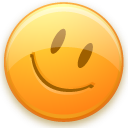

In [6]:
smiley = Image.open(buffer)
smiley

##### Open a PIL image from the object store / file

(320, 240)


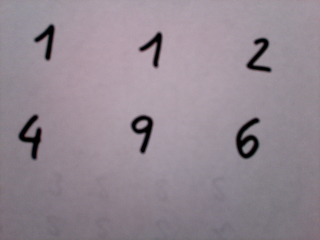

In [7]:
image = Image.open(project.get_file('digits.jpg'))
print(image.size)
image

## Image segmentation

##### Convert to gray scale

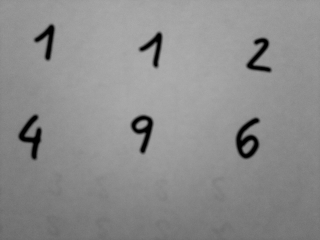

In [8]:
grayscale = image.convert('L')
grayscale

##### Invert the image and enhance the contrast

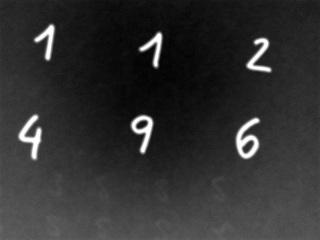

In [9]:
inverted = ImageOps.autocontrast(ImageOps.invert(grayscale))
inverted

##### Show the histogram of the inverted image
  
      0 ... black
    255 ... white
    
One can see that the digits are really white and the background ranges up to a value of about 100.

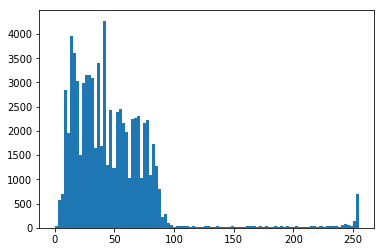

In [10]:
plt.hist( inverted.getdata(), bins=100);

##### Set all values below a thresholt to 0 and keep values above

The threshold of 150 is manually estimated from the histogram above

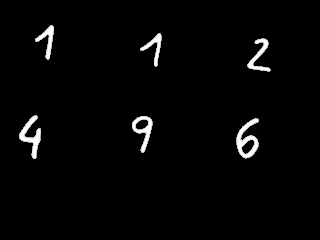

In [11]:
threshold = 150
thresholded = inverted.point(lambda x: 0 if x < threshold else x)
thresholded

##### For finding individual digits we first convers the PIL image to a numpy array and make a binary mask out of it

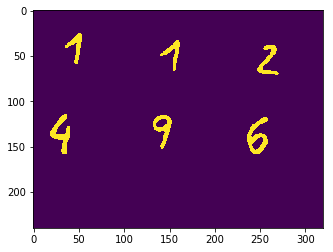

In [12]:
binary = np.array(thresholded) > 0
plt.imshow(binary);

##### We use `ndimage.label` from scipy to find the connected components

It returns the array `labaled` where each pixel is assigned either 0 (background) or `1 ... n_objects`.

In [13]:
labeled, n_objects = ndimage.label(binary, structure=ndimage.generate_binary_structure(2,2))
n_objects

6

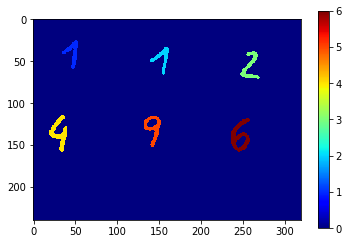

In [14]:
plt.imshow(labeled, cmap='jet');
plt.colorbar();

##### Now we apply `ndimage.find_objects` to find the bouding boxes around the labeled data

We also sort them and filter out to small objects (less the 100 pixels)

In [15]:
# find rectangular boundig boxes around the labeled image
locations = ndimage.find_objects(labeled)

# keep only locations / bouding boxes with more then 100 pixels
locations = [o for o in locations if area(o) > 100]

# sort bounding boxes (locations) from top-left to bottom-right
locations = sorted(locations, key=LocationOrder)
locations

[(slice(25, 60, None), slice(35, 54, None)),
 (slice(33, 67, None), slice(140, 162, None)),
 (slice(38, 72, None), slice(247, 271, None)),
 (slice(115, 159, None), slice(19, 41, None)),
 (slice(116, 153, None), slice(132, 153, None)),
 (slice(118, 159, None), slice(236, 259, None))]

##### Cut out the found objects

Now as we have found our objects we cut them out, and put them into a square image of a given size with a given border.
We encapsulate all this functionality in the following function:

In [16]:
def cut_out_object(image, loc, digit_size=20, image_size=28):
    """
    Cut out the object at the location loc and return a square image of given width and border.
    
    This is done in the same way as the MNIST data is generated:
        The original black and white (bilevel) images from NIST were size normalized to fit in a 
        20x20 pixel box while preserving their aspect ratio. The resulting images contain grey
        levels as a result of the anti-aliasing technique used by the normalization algorithm. 
        The images were centered in a 28x28 image by computing the center of mass of the pixels,
        and translating the image so as to position this point at the center of the 28x28 field.
        See http://yann.lecun.com/exdb/mnist/.
        
    """
    
    # a location consits of the y (vertical/row) and x (horizontal/column) slice
    y, x = loc
    
    # build the bounding box
    bbox = (x.start, y.start, x.stop, y.stop)
    
    # number of pixels in x and y direction
    nx = x.stop - x.start
    ny = y.stop - y.start

    # the maximum
    n = max(nx, ny)
    
    # crop the object out of the image
    obj = image.crop(bbox)
    
    # generate a square of sie n x n which can hold the object
    square = Image.new('L', (n, n), 0)
    
    # now paste the object centered into the square
    square.paste(obj, (int((n - nx) / 2 + 0.5), int((n - ny) / 2 + 0.5)))
    
    # scale the square to digit_size x digit_size
    scaled = square.resize((digit_size, digit_size))
    cy, cx = ndimage.measurements.center_of_mass(np.array(scaled))
        
    # now we generate a final image of image_size x image_size ...
    final = Image.new('L', (image_size, image_size), 0)

    # ... where we paste in the scaled version of the object such that the center of mass is
    # at the center of the final image
    border = (int(image_size / 2 + 0.5 - cx), int(image_size / 2 + 0.5 - cy))
    final.paste(scaled, border)

    return final

##### Display the found objects

In [17]:
for loc in locations:
    display(cut_out_object(thresholded, loc))

##### Display the found objects using matplot lib

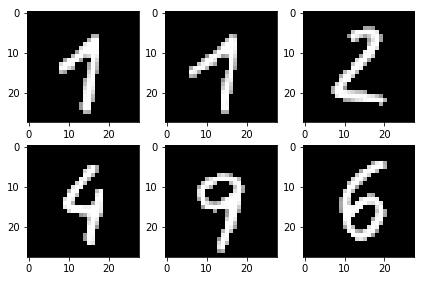

In [18]:
i = 0
plt.figure(figsize=(7,7))
for loc in locations:
    plt.subplot(3,3,i+1)
    plt.imshow(
        np.array(cut_out_object(thresholded, loc)),
        cmap='gray', interpolation='none'
    )
    i += 1